In [1]:
import pandas as pd
import networkx as nx

In [2]:
string_df_7227_dt = pd.read_csv("organismos_string/STRING_Scores/7227_protein_detailed.txt", sep=" ")
string_df_7227_dt

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,7227.FBpp0070001,7227.FBpp0293850,0,0,0,151,0,0,0,150
1,7227.FBpp0070001,7227.FBpp0087873,0,0,0,153,0,0,0,152
2,7227.FBpp0070001,7227.FBpp0079990,0,0,0,167,0,0,0,167
3,7227.FBpp0070001,7227.FBpp0080090,0,0,0,298,0,0,0,298
4,7227.FBpp0070001,7227.FBpp0075453,0,0,0,446,0,0,0,446
...,...,...,...,...,...,...,...,...,...,...
4343793,7227.FBpp0306233,7227.FBpp0080342,0,0,0,138,0,0,260,334
4343794,7227.FBpp0306233,7227.FBpp0080913,0,0,0,149,0,0,544,595
4343795,7227.FBpp0306233,7227.FBpp0080607,0,0,0,147,0,0,636,676
4343796,7227.FBpp0306233,7227.FBpp0081073,0,0,0,91,0,0,772,783


In [3]:
# Proteínas com experimentais ou bancos curados
df_curated = string_df_7227_dt[(string_df_7227_dt['experimental'] > 0) | (string_df_7227_dt['database'] > 0)]
df_curated

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
894,7227.FBpp0070005,7227.FBpp0086903,0,0,0,0,87,137,0,178
895,7227.FBpp0070005,7227.FBpp0086091,0,0,0,109,86,0,0,150
896,7227.FBpp0070005,7227.FBpp0290084,0,0,0,0,43,177,0,178
897,7227.FBpp0070005,7227.FBpp0082594,0,0,0,0,43,177,0,178
899,7227.FBpp0070005,7227.FBpp0085523,0,0,0,0,43,177,0,178
...,...,...,...,...,...,...,...,...,...,...
4343743,7227.FBpp0306232,7227.FBpp0087347,0,0,0,148,249,0,0,332
4343744,7227.FBpp0306232,7227.FBpp0086694,43,0,0,213,85,0,133,322
4343745,7227.FBpp0306232,7227.FBpp0081384,115,0,0,541,621,0,432,900
4343747,7227.FBpp0306232,7227.FBpp0074086,200,0,0,982,999,0,198,999


## Funções dos grafos

In [4]:
# protein_interaction_df = string_df_4932

protein_interaction_df = df_curated

In [5]:
# Enumerando as proteínas da Cerevisiae

protein_map = { v:k for k, v in enumerate(set(protein_interaction_df.loc[:, "protein1"]).union(
    set(protein_interaction_df.loc[:, "protein2"]))) }


print(len(protein_map))

11316


In [6]:
protein_map

{'7227.FBpp0112228': 0,
 '7227.FBpp0292805': 1,
 '7227.FBpp0070949': 2,
 '7227.FBpp0077151': 3,
 '7227.FBpp0077011': 4,
 '7227.FBpp0079963': 5,
 '7227.FBpp0081556': 6,
 '7227.FBpp0082276': 7,
 '7227.FBpp0079983': 8,
 '7227.FBpp0080364': 9,
 '7227.FBpp0079880': 10,
 '7227.FBpp0292798': 11,
 '7227.FBpp0071354': 12,
 '7227.FBpp0075507': 13,
 '7227.FBpp0302921': 14,
 '7227.FBpp0072094': 15,
 '7227.FBpp0080552': 16,
 '7227.FBpp0087663': 17,
 '7227.FBpp0289090': 18,
 '7227.FBpp0297254': 19,
 '7227.FBpp0077962': 20,
 '7227.FBpp0083769': 21,
 '7227.FBpp0082810': 22,
 '7227.FBpp0073058': 23,
 '7227.FBpp0077974': 24,
 '7227.FBpp0085834': 25,
 '7227.FBpp0099655': 26,
 '7227.FBpp0078113': 27,
 '7227.FBpp0300615': 28,
 '7227.FBpp0086965': 29,
 '7227.FBpp0088920': 30,
 '7227.FBpp0081879': 31,
 '7227.FBpp0088658': 32,
 '7227.FBpp0081680': 33,
 '7227.FBpp0076588': 34,
 '7227.FBpp0071864': 35,
 '7227.FBpp0083500': 36,
 '7227.FBpp0305749': 37,
 '7227.FBpp0084966': 38,
 '7227.FBpp0070814': 39,
 '7227.FBp

In [7]:
len(protein_map)

11316

In [8]:
# Mapeando as proteínas para gerar o grafo

def mapProtein(protein_interaction_df, protein_map):
    
    protein_interation_masked = pd.DataFrame()
    
    proteins = ['protein1', 'protein2']
    
    for p in proteins:
        protein_interation_masked[p] = protein_interaction_df[p].map(protein_map)
    
    return protein_interation_masked

In [9]:
protein_interation_masked = mapProtein(protein_interaction_df, protein_map)
protein_interation_masked

,protein1,protein2
894,10994,4061
895,10994,2489
896,10994,6929
897,10994,9489
899,10994,10613
...,...,...
4343743,583,11256
4343744,583,5681
4343745,583,5167
4343747,583,10486


In [10]:
def generateGraph(protein_interation_masked):

    # Gerar grafo a partir do mapeamento do dataframe do Pandas
    protein_interaction_graph = nx.from_pandas_edgelist(
        protein_interation_masked, 
        source = "protein1", 
        target = "protein2"
    )
    
    return protein_interaction_graph

In [11]:
def generateDF(protein_interaction_graph):
    return nx.to_pandas_edgelist(protein_interaction_graph)

In [12]:
# Geração do grafo de PPI

graph = generateGraph(protein_interation_masked)
df_graph = generateDF(graph)
df_graph

,source,target
0,10994,4061
1,10994,2489
2,10994,6929
3,10994,9489
4,10994,10613
...,...,...
1038453,8648,9821
1038454,10606,6353
1038455,221,6145
1038456,1878,2834


In [13]:
# Medidas de Centralidade
import time

seconds_ini = time.time()

# Degree Centrality
degree = nx.degree_centrality(graph)

In [14]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(graph)

In [15]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(graph)

In [16]:
# Closeness Centrality
closeness = nx.closeness_centrality(graph)

In [17]:
# Clustering
clustering = nx.clustering(graph)

seconds_fini = time.time()

print("Seconds since epoch =", seconds_fini - seconds_ini)

Seconds since epoch = 8152.864541053772


In [18]:
# Criando um Dataframe
from collections import OrderedDict

degree_ordered = OrderedDict(sorted(degree.items()))
eigenvector_ordered = OrderedDict(sorted(eigenvector.items()))
betweenness_ordered = OrderedDict(sorted(betweenness.items()))
closeness_ordered = OrderedDict(sorted(closeness.items()))
clustering_ordered = OrderedDict(sorted(clustering.items()))


protein_features = pd.concat([pd.Series(list(protein_map.keys())),
                              pd.Series(list(degree_ordered.values())), 
                              pd.Series(list(eigenvector_ordered.values())),
                              pd.Series(list(betweenness_ordered.values())), 
                              pd.Series(list(closeness_ordered.values())),
                              pd.Series(list(clustering_ordered.values()))], axis=1)

protein_features.columns = ["Protein_key",
                            "DegreeCentrality",
                            "EigenvectorCentrality",
                            "BetweennessCentrality",
                            "ClosenessCentrality",
                            "Clustering"]
                           

In [19]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering
0,7227.FBpp0112228,0.050906,0.019763,0.000150,0.444818,0.208164
1,7227.FBpp0292805,0.000619,0.000076,0.000000,0.307274,1.000000
2,7227.FBpp0070949,0.001061,0.000230,0.000005,0.341165,0.106061
3,7227.FBpp0077151,0.007247,0.001527,0.000017,0.376307,0.386932
4,7227.FBpp0077011,0.102519,0.038830,0.001129,0.488365,0.197406
...,...,...,...,...,...,...
11311,7227.FBpp0076790,0.012108,0.005630,0.000039,0.419425,0.422606
11312,7227.FBpp0075257,0.003182,0.000908,0.000009,0.362155,0.706349
11313,7227.FBpp0291347,0.061511,0.025098,0.000483,0.467915,0.244997
11314,7227.FBpp0100048,0.030490,0.005293,0.000770,0.439263,0.111139


In [20]:
protein_features.to_csv('data_org/proteins_features_droso_tmp.csv', index=False)

In [21]:
# Rotulando as proteínas essencias

dataset_essential = pd.read_csv('essential_genes.csv')

protein_features = pd.read_csv('data_org/proteins_features_droso_tmp.csv')

dataset_essential[dataset_essential['Code_Organism'] == 'DEG2002']

,Organism,Reference,Name,Essential_Genes,Method,Code_Organism,Date,Code_Gene_DEG,Gene,Function,RefSeq,Seq_Gene,Seq_Prot,Locus
1110,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020001,mei-2,defective MEIosis family member (mei-2),NC_003279,ATGTCAGGGCTTGACGACCGGAAAAAACTAACACATGCAAAAAATA...,MSGLDDRKKLTHAKNRKPLNDIPKSAENRPNTRSTSSRRGAEKDVP...,6238.CBG18869
1111,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020002,dad-1,DAD (Defender against Apoptotic Death) homolog...,NC_003279,ATGGCGGCTCAAGTAGTTCCAGTTCTCTCGAAACTGTTCGATGACT...,MAAQVVPVLSKLFDDYQKTTSSKLKIIDAYMTYILFTGIFQFIYCL...,6239.F57B10.10
1112,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020003,F57B10.3,F57B10.3a,NC_003279,ATGTTCGTAGCCCTGGGCGCTCAAATTTATCGGCAATATTTCGGAC...,MFVALGAQIYRQYFGRRGMAMANNSSVANKVCLIVIDGWGVSEDPY...,6239.F57B10.3a
1113,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020004,F57B10.8,F57B10.8,NC_003279,ATGGCGCCTATTCCAAAAAAGAAGAAGAAAATTGTGAGAAAATCGA...,MAPIPKKKKKIVRKSIKKPVVEEDMKMEEEKEMLEPKEESIETDNN...,6239.F57B10.8
1114,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020005,F59A3.3,F59A3.3,NC_003279,ATGCTTACTTCTCGTGCACTTCGAATTCCACGTAAACCATTTGTGG...,MLTSRALRIPRKPFVDLDYARHMPSAYVERTKRTVPRKVFGDRFGA...,6239.F59A3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020290,Y43F8C.8,Y43F8C.8,NC_003283,ATGCTCCGAAGCTTGCTCAAGTCTCGACAGGTGATTTGCGGGCTCC...,MLRSLLKSRQVICGLRELRALSTSQGNESIIDFVDTVTETSEAQNQ...,6239.Y43F8C.8
1400,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020291,nuo-5,NADH Ubiquinone Oxidoreductase family member (...,NC_003283,ATGCATCGCGTCGGTGGACAAATTGTCCGCGGAGTGTCGAAGGCTC...,MHRVGGQIVRGVSKAQQKRSLSVAAPAPPKKVEVFIDDKKVLVDPG...,6239.Y45G12B.1a
1401,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020292,Y47D7A.14,Y47D7A.14,NC_003283,ATGGGTTGCTCGGCGGCCACATTTATCCTAGTGGCACTTTTCGGGT...,MGCSAATFILVALFGSSSWMGTNSVWMQLPLLTSELPEQWNLPSYL...,6239.Y47D7A.14b
1402,Caenorhabditis elegans,"Kamath RS, et al (2003). Systematic functional...",worm,294,RNA interference,DEG2002,2018-11-11,DEG20020293,Y49A3A.1,Y49A3A.1,NC_003283,ATGCCCCCCAAGATACACCCCAGTTTGTCTACTGGATACTTTGTCT...,MPPKIHPSLSTGYFVSLDTMPPKNLCHQKVCHLGMKAPKKNALVGF...,6239.Y49A3A.1


In [29]:
sac_proteins = list(dataset_essential[dataset_essential['Code_Organism'] == 'DEG2007']['Locus'])

protein_features['is_essential'] = protein_features.apply(lambda x: 1 if x.Protein_key in sac_proteins 
                                                          else 0, axis=1)

In [30]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,7227.FBpp0112228,0.050906,0.019763,0.000150,0.444818,0.208164,0
1,7227.FBpp0292805,0.000619,0.000076,0.000000,0.307274,1.000000,0
2,7227.FBpp0070949,0.001061,0.000230,0.000005,0.341165,0.106061,0
3,7227.FBpp0077151,0.007247,0.001527,0.000017,0.376307,0.386932,0
4,7227.FBpp0077011,0.102519,0.038830,0.001129,0.488365,0.197406,0
...,...,...,...,...,...,...,...
11311,7227.FBpp0076790,0.012108,0.005630,0.000039,0.419425,0.422606,1
11312,7227.FBpp0075257,0.003182,0.000908,0.000009,0.362155,0.706349,0
11313,7227.FBpp0291347,0.061511,0.025098,0.000483,0.467915,0.244997,0
11314,7227.FBpp0100048,0.030490,0.005293,0.000770,0.439263,0.111139,0


In [31]:
protein_features.to_csv('data_org/proteins_features_droso.csv', index=False)

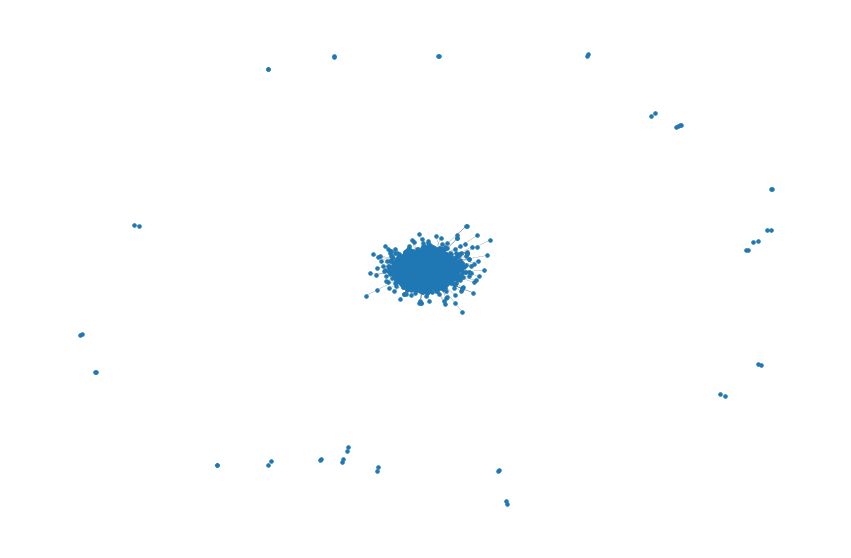

In [32]:
# Graph 

# Fonte: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html

from random import randint
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)


plt.figure(figsize=(15,10))
plt.axis('off') 
nx.draw_networkx(graph, pos=pos, node_size=12, with_labels=False, width=0.15)

### Visualização de dados

In [36]:
df = pd.read_csv("data_org/proteins_features_droso.csv")
df

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,7227.FBpp0112228,0.050906,0.019763,0.000150,0.444818,0.208164,0
1,7227.FBpp0292805,0.000619,0.000076,0.000000,0.307274,1.000000,0
2,7227.FBpp0070949,0.001061,0.000230,0.000005,0.341165,0.106061,0
3,7227.FBpp0077151,0.007247,0.001527,0.000017,0.376307,0.386932,0
4,7227.FBpp0077011,0.102519,0.038830,0.001129,0.488365,0.197406,0
...,...,...,...,...,...,...,...
11311,7227.FBpp0076790,0.012108,0.005630,0.000039,0.419425,0.422606,1
11312,7227.FBpp0075257,0.003182,0.000908,0.000009,0.362155,0.706349,0
11313,7227.FBpp0291347,0.061511,0.025098,0.000483,0.467915,0.244997,0
11314,7227.FBpp0100048,0.030490,0.005293,0.000770,0.439263,0.111139,0


In [37]:
df_essential = df[df['is_essential'] == 1]
df_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
32,7227.FBpp0088658,0.037296,0.014157,0.000199,0.443833,0.236640,1
59,7227.FBpp0072164,0.037649,0.014198,0.000227,0.446945,0.198608,1
68,7227.FBpp0078336,0.019885,0.008289,0.000087,0.435207,0.313492,1
122,7227.FBpp0099825,0.005479,0.002154,0.000004,0.394043,0.356425,1
127,7227.FBpp0079648,0.034026,0.012406,0.000198,0.444853,0.223810,1
...,...,...,...,...,...,...,...
11228,7227.FBpp0083801,0.035440,0.010177,0.000696,0.445666,0.174015,1
11235,7227.FBpp0076320,0.042863,0.016233,0.000647,0.458132,0.250567,1
11259,7227.FBpp0297103,0.016615,0.008599,0.000197,0.425002,0.499204,1
11307,7227.FBpp0111799,0.018825,0.005665,0.000181,0.420431,0.157853,1


In [38]:
df_non_essential = df[df['is_essential'] == 0]
df_non_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,7227.FBpp0112228,0.050906,0.019763,0.000150,0.444818,0.208164,0
1,7227.FBpp0292805,0.000619,0.000076,0.000000,0.307274,1.000000,0
2,7227.FBpp0070949,0.001061,0.000230,0.000005,0.341165,0.106061,0
3,7227.FBpp0077151,0.007247,0.001527,0.000017,0.376307,0.386932,0
4,7227.FBpp0077011,0.102519,0.038830,0.001129,0.488365,0.197406,0
...,...,...,...,...,...,...,...
11310,7227.FBpp0088416,0.032435,0.009508,0.000377,0.443307,0.247599,0
11312,7227.FBpp0075257,0.003182,0.000908,0.000009,0.362155,0.706349,0
11313,7227.FBpp0291347,0.061511,0.025098,0.000483,0.467915,0.244997,0
11314,7227.FBpp0100048,0.030490,0.005293,0.000770,0.439263,0.111139,0


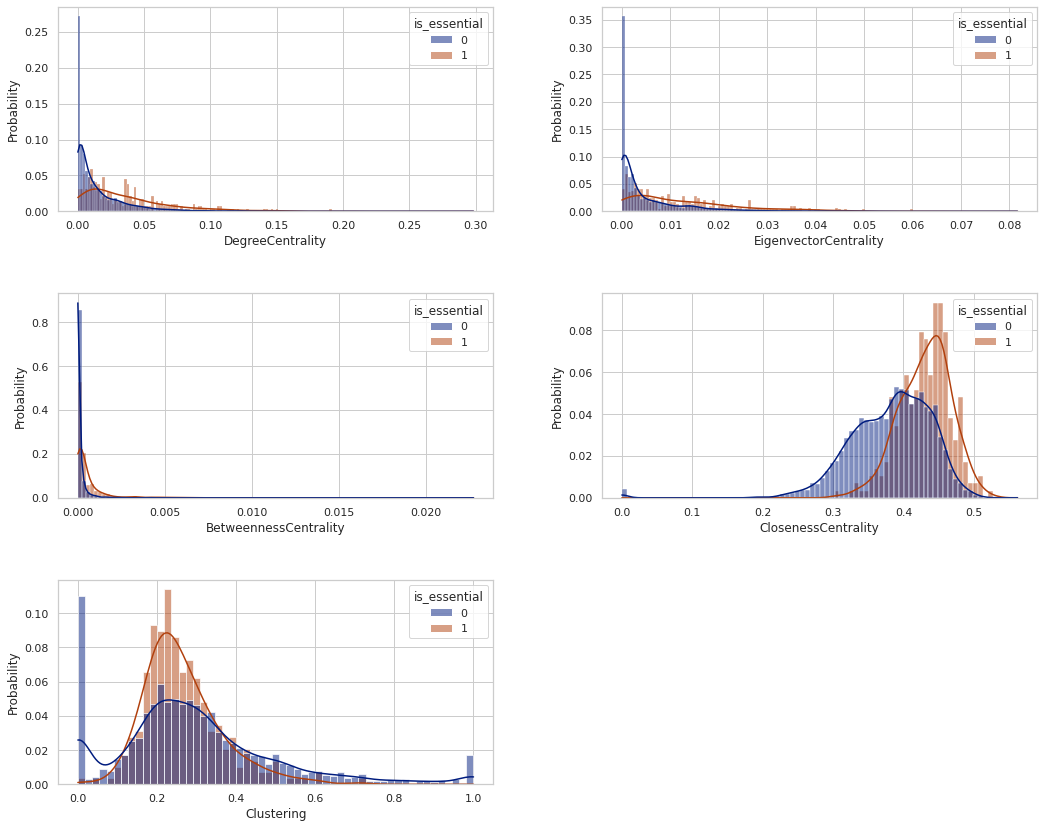

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16,12)

# Define as configurações dos plots
# Cada plot terá o mesmo tamanho de figuras (8,10)
#plt.style.use("ggplot")

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")


# Dados para cada subplot

plt.subplot(321)
sns.histplot(data=df, x="DegreeCentrality", hue="is_essential", 
             stat="probability", common_norm=False, kde=True)

plt.subplot(322)
sns.histplot(data=df, x="EigenvectorCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(323)
sns.histplot(data=df, x="BetweennessCentrality", hue="is_essential", bins = 100,
            stat="probability", common_norm=False, kde=True)

plt.subplot(324)
sns.histplot(data=df, x="ClosenessCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(325)
sns.histplot(data=df, x="Clustering", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)


plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results.jpg")
plt.show()
